# Hybrid Test Bench 2-DoFs - case study

This test bench consists of a steel frame equipped with two electro-mechanical actuators and a force transducer. The horizontal actuator applies a force $f_h$ [N] to the beam tip and measures the corresponding displacement $u_h$ [mm]. The vertical actuator applies a displacement $u_v$ [mm] to the beam tip and measures the corresponding reaction force $f_v$ [N].

<img src="assets\test_bench_2dof.jpg" alt="Test Bench 1-DoF" height="500">

Below is a schematic of the setup with main dimensions in [mm] and indication of forces/displacements, which has to be used to produce a finite-element model. For each part of the test bench (frame, supports and specimen) cross-sections are given with main dimensions. All parts are made of steel (elastic modulus $E=210e3$ MPa), expect for the specimen, which is made in aluminum (elastic modulus $E=70e3$ MPa).

Note that one of the nodes is missing a number.

<img src="assets\test_bench_2dof_CAD.png" alt="Test Bench 1-DoF" height="500">

As you can see, the figure already reports a tentative numbering of nodes (1-12), which you can use to define the finite-element model. The coordinates of each node, shall be expressed w.r.t. coordinate system x-y-z and computed based on the dimensions of the drawing.

The following loadings are applied to the specimen:

$u_v(t) = 20 \sin(4\pi t)$ [mm]

$f_h(t) = 100 \sin(2\pi t)$ [N]

The corresponding $f_v(t)$ and $u_h(t)$ are measured.

The bending stiffness $K_b$ of the specimen defines the proportionality between $u_v$ and $f_v$:

$f_v = K_b u_v$

The axial stiffness $K_a$ of the specimen defines the proportionality between $u_h$ and $f_h$:

$f_h = K_a u_h$

# Assignment

In this project both the Digital and the Physical Twin are represented by the same finite-element model:
* The PHYSICAL TWIN is simulated considering that actual material for the specimen, which is aluminum (elastic modulus $E=70e3$ MPa).
* The DIGITAL TWIN assumes an initial guess for the material parameters of the specimen, which is close to aluminum (elastic modulus $E=100e3$ MPa) but not exact.
* A "model calibration" service shall be developed to estimate the correct value for the elastic modulus of the specimen, by comparing the force displacement relationships $f_h = K_a u_h$ and $f_v = K_b u_v$ between DIGITAL TWIN and PHYSICAL TWIN.
* In this project, 1D elements (beam) are sufficient to construct the finite-element model of each of the selected test bench.

# Building our finite-element model in YaFEM

For our case study we will use YaFEM, which is a toolbox used to create simple finite-element models made of 1D, 2D and 3D elements.

We start with building a finite-element model for a simple cantilever beam subjected to a vertical tip displacement and horizontal tip force. Same logic as for the one one the next image, but we have the beam which is coloured green on the test bench image - between nodes 9 and 10.

<img src="assets\cantilever_beam.jpg" alt="Cantilever beam example" height="200">

Step 1: define model parameters

In [1]:
_l = 600.0  # length of the beam [mm]
_E = 210e3  # Young's modulus [N/mm^2]

# cross-section parameters (see the sketch above)
_b = 40.0  # cross section width [mm]
_h = 60.0  # cross section height [mm]
_s = 5.0  # cross section thickness [mm]
_A = _b * _h - (_b - 2 * _s) * (_h - 2 * _s)  # cross-section area [mm2]
_Ixx = _b * _h ** 3 / 12 - (_b - 2 * _s) * (_h - 2 * _s) ** 3 / 12  # moment of inertia about x-axis [mm4]
_Iyy = _h * _b ** 3 / 12 - (_h - 2 * _s) * (_b - 2 * _s) ** 3 / 12  # moment of inertia about y-axis [mm4]

# parameters of the applied boundary conditions (displacements and forces)
_uv = 5.0  # vertical displacement applied to node 2 [mm]
_fh = 100.0  # horizontal force applied to node 2 [N]

Step 2: import YaFEM modules

In [2]:
from yafem.nodes import *
from yafem.elem import *
from yafem.model import *
from yafem.simulation import *

Step 3: create the FE model nodes

In [3]:
# nodal parameters
nodes_pars = {'nodal_data': np.array([[1, 0.0, 0.0, 0.0],
                                      [2, _l, 0.0, 0.0]])}

# create the nodes
nodes = nodes(nodes_pars)

Step 4: create the FE model elements

In [4]:
# parameters of the element
beam3d_pars = {}
beam3d_pars['shape'] = 'generic'
beam3d_pars['A'] = _A
beam3d_pars['Ixx'] = _Ixx
beam3d_pars['Iyy'] = _Iyy
beam3d_pars['E'] = _E
beam3d_pars['Jv'] = beam3d_pars['Ixx'] + beam3d_pars['Iyy']
beam3d_pars['nodal_labels'] = [1, 2]

# initialization of the element list
elements = [beam3d(nodes, beam3d_pars)]

Step 5: create the FE model

In [5]:
# model parameters
model_pars = {}

# constrained degrees of freedom (all dofs of node 1)
model_pars['dofs_c'] = np.array([[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6]])

# degrees of freedom subjected to force history (horizontal dofs of node 2)
model_pars['dofs_f'] = np.array([[2, 1]])

# degrees of freedom subjected to displacement history (vertical dofs of node 2)
model_pars['dofs_u'] = np.array([[2, 3]])

# force history (21 steps)
model_pars['g_f'] = np.linspace(0, _fh, 21)

# displacement history (21 steps)
model_pars['g_u'] = np.linspace(0, _uv, 21)

# create the model
model = model(nodes, elements, model_pars)

# list of model dofs (left column is node number, right column is the dof number)
model.dofs

array([[2, 1],
       [2, 2],
       [2, 3],
       [2, 4],
       [2, 5],
       [2, 6]])

Step 6: create and execute the simulation

In [6]:
# simulation parameters
simulation_pars = {}

# create the simulation
my_simulation = simulation(model, simulation_pars)

# perform static analysis (u: displacements, l: applied forces, r: restoring force)
[u, l, r] = my_simulation.static_analysis()

print("Displacements: ", u)
print("Applied forces: ", l)
print("Restoring forces: ", r)

step 1 converged in 1 iterations with residual 0.0
step 2 converged in 1 iterations with residual 0.0
step 3 converged in 1 iterations with residual 2.533397151339718e-16
step 4 converged in 1 iterations with residual 1.948855009542913e-13
step 5 converged in 1 iterations with residual 1.5606478487777726e-13
step 6 converged in 1 iterations with residual 2.6028271925092146e-13
step 7 converged in 1 iterations with residual 2.2320744978286588e-13
step 8 converged in 1 iterations with residual 1.9079615774162621e-16
step 9 converged in 1 iterations with residual 1.6966474305040974e-16
step 10 converged in 1 iterations with residual 1.563796169202795e-13
step 11 converged in 1 iterations with residual 1.4219116427499392e-13
step 12 converged in 1 iterations with residual 3.8191797009497927e-16
step 13 converged in 1 iterations with residual 2.406963186199065e-13
step 14 converged in 1 iterations with residual 2.2352717717389e-13
step 15 converged in 1 iterations with residual 2.0864549570

Step 7: post-process the results

5942.708333333334

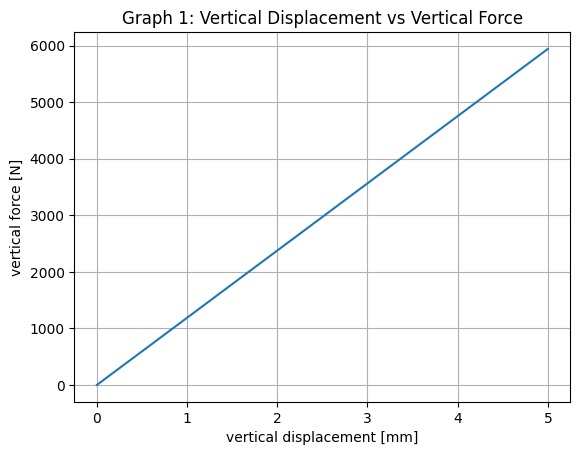

In [7]:
# First Graph
plt.plot(u[model.find_dofs([[2, 3]]).squeeze(), :], l[0, :])
plt.xlabel('vertical displacement [mm]')
plt.ylabel('vertical force [N]')
plt.title('Graph 1: Vertical Displacement vs Vertical Force')
plt.grid()

# this is done to check the correctness of the results
_kb = 3 * _E * _Ixx / _l ** 3  # theoretical bendind stiffness
_fv_max = _kb * _uv  # theoretical maximum vertical force
_fv_max

Graph 1 plots the relationship between the vertical displacement and the vertical force applied to the beam. The vertical displacement is measured at node 2 in the finite-element model, and the corresponding vertical force is plotted.

0.00031746031746031746

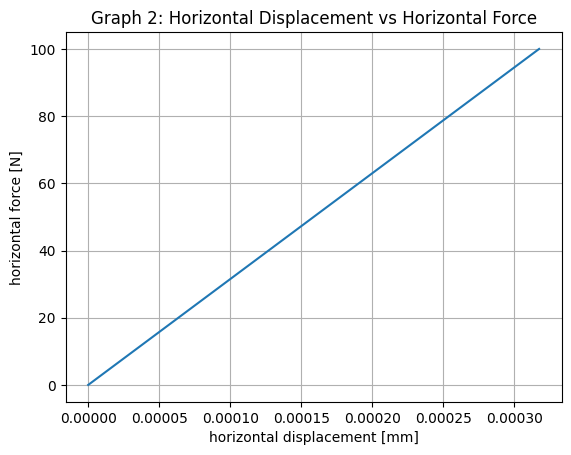

In [8]:
# Second Graph
plt.plot(u[model.find_dofs([[2, 1]]).squeeze(), :], model.g_f[0, :])
plt.xlabel('horizontal displacement [mm]')
plt.ylabel('horizontal force [N]')
plt.title('Graph 2: Horizontal Displacement vs Horizontal Force')
plt.grid()

# checks the correctness of the results
_ka = _E * _A / _l  # theoretical axial stiffness
_uh_max = _fh / _ka  # theoretical maximum horizontal displacement
_uh_max

Graph 2 plots the relationship between the horizontal displacement and the horizontal force applied to the beam. The horizontal displacement is measured at node 2 in the finite-element model, and the corresponding horizontal force is plotted.